In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load dataset, ensure that we have balanced classes 

In [58]:
complete_data = pd.read_csv('../resources/data/credit-g/dataset_31_credit-g.csv')

bad = complete_data[complete_data['class'] != 'good']
good = complete_data[complete_data['class'] == 'good'].sample(len(bad))

data = pd.concat([good, bad])

In [59]:
data

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
210,'no checking',9,'critical/other existing credit',radio/tv,3074,'no known savings','1<=X<4',1,'male single',none,...,'real estate',33,none,own,2,skilled,2,none,yes,good
859,'no checking',9,'existing paid','new car',3577,'100<=X<500','1<=X<4',1,'male single',guarantor,...,'real estate',26,none,rent,1,skilled,2,none,no,good
782,'0<=X<200',12,'no credits/all paid',retraining,1410,'<100','1<=X<4',2,'male single',none,...,'real estate',31,none,own,1,'unskilled resident',1,yes,yes,good
975,'>=200',24,'existing paid',radio/tv,1258,'500<=X<1000','1<=X<4',3,'female div/dep/mar',none,...,car,57,none,own,1,'unskilled resident',1,none,yes,good
142,'<0',27,'existing paid',radio/tv,3416,'<100','1<=X<4',3,'male single',none,...,car,27,none,own,1,'high qualif/self emp/mgmt',1,none,yes,good
836,'no checking',12,'existing paid',radio/tv,886,'no known savings','1<=X<4',4,'female div/dep/mar',none,...,car,21,none,own,1,skilled,1,none,yes,good
600,'0<=X<200',7,'existing paid',radio/tv,2329,'<100','<1',1,'female div/dep/mar',guarantor,...,'real estate',45,none,own,1,skilled,1,none,yes,good
389,'no checking',9,'existing paid',business,1449,'<100','4<=X<7',3,'female div/dep/mar',none,...,car,27,none,own,2,skilled,1,none,yes,good
52,'no checking',12,'existing paid',radio/tv,1262,'<100','1<=X<4',3,'male single',none,...,car,25,none,own,1,skilled,1,none,yes,good
442,'0<=X<200',20,'delayed previously',other,2629,'<100','1<=X<4',2,'male single',none,...,car,29,bank,own,2,skilled,1,yes,yes,good


### Train a logistic regression model, using grid search and k-fold cross-validation

In [63]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

def labels_from(df):
    return np.array(df['class'] == 'good')

train_data, heldout_data = train_test_split(data, test_size=0.2)
test_data, target_data = train_test_split(heldout_data, test_size=0.5)

y_train = labels_from(train_data)
y_test = labels_from(test_data)
y_target = labels_from(target_data)

categorical_columns = ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'other_parties', 
 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']

numeric_columns = ['duration', 'credit_amount', 'existing_credits', 'installment_commitment', 'age', 'num_dependents']

feature_transformation = ColumnTransformer(transformers=[
    ('categorical_features', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('scaled_numeric', StandardScaler(), numeric_columns)
])

param_grid = {
    'learner__loss': ['log'],
    'learner__penalty': ['l2', 'l1', 'elasticnet'],
    'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
}

pipeline = Pipeline([
    ('features', feature_transformation), 
    ('learner', SGDClassifier(max_iter=1000))])

search = GridSearchCV(pipeline, param_grid, cv=5)
model = search.fit(train_data, y_train)

In [64]:
score_on_train_data = accuracy_score(y_train, model.predict(train_data))
score_on_noncorrupted_test_data = accuracy_score(y_test, model.predict(test_data))
score_on_noncorrupted_target_data = accuracy_score(y_target, model.predict(target_data))

print("score on train data: ", score_on_train_data)
print("score on test data: ", score_on_noncorrupted_test_data)
print("score on target data: ", score_on_noncorrupted_target_data)

score on train data:  0.75
score on test data:  0.6833333333333333
score on target data:  0.65


### Introduce errors (missing values) into unseen test data, record resulting class probability entropies and accuracy score as inputs for the meta regressor

In [65]:
import random
from scipy.stats import entropy
from tqdm import tqdm

def delete_cells(df, fraction, columns):
    # we operate on a copy of the data
    corrupted_df = df.copy(deep=True)
    
    row_indexes = [row for row in range(corrupted_df.shape[0])]
    # pick random examples
    num_rows_to_pick = int(round(fraction * len(row_indexes)))
    for random_row_index in random.sample(row_indexes, num_rows_to_pick):           
        # delete all specified values in the target columns
        for column in columns:
            column_index = df.columns.get_loc(column)
            corrupted_df.iat[random_row_index, column_index] = 'n/a'
    
    return corrupted_df

generated_training_data = []

for num_columns_affected in tqdm(range(1, 11)):
    for fraction_of_values_to_delete in [0.05, 0.25, 0.5, 0.75, 0.99]:    
        for _ in range(0, 50):        
            columns_affected = np.random.choice(categorical_columns, num_columns_affected)        

            corrupted_test_data = delete_cells(test_data, fraction_of_values_to_delete, columns_affected)

            predictions = model.predict_proba(corrupted_test_data)
                        
            entropy_good = entropy(np.transpose(predictions)[0])
            entropy_bad = entropy(np.transpose(predictions)[1])           
            #tammo = np.mean([np.max(prediction) for prediction in predictions])

            score_on_corrupted_test_data = accuracy_score(y_test, model.predict(corrupted_test_data))

            generated_training_data.append([entropy_good, entropy_bad, score_on_corrupted_test_data])

100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


### Plot relation between entropy of predicted class probabilities and accuracy

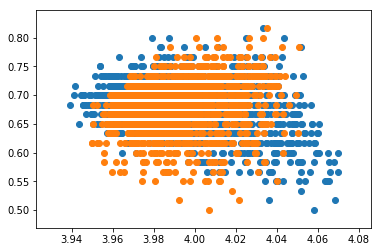

In [66]:
entropies_good = np.transpose(generated_training_data)[0]
entropies_bad = np.transpose(generated_training_data)[1]
accuracies = np.transpose(generated_training_data)[2]

plt.scatter(entropies_good, accuracies)
plt.scatter(entropies_bad, accuracies)
plt.show()

### Fit a simple regression model to the generated training data

In [49]:
from sklearn.linear_model import LinearRegression

X = np.array(generated_training_data)[:,:2]
y = np.array(generated_training_data)[:,2]

meta_regressor_pipeline = Pipeline([
    ('scaling', StandardScaler()), 
    ('learner', LinearRegression())
])

meta_regressor = meta_regressor_pipeline.fit(X, y)

### Evaluate regression model in predicting effects of errors in the unseen target data

In [50]:
predicted_scores = []
true_scores = []

for num_columns_affected in tqdm(range(1, 11)):
    for fraction_of_values_to_delete in [0.05, 0.25, 0.5, 0.75, 0.99]:    
        for _ in range(0, 50):        
            columns_affected = np.random.choice(categorical_columns, num_columns_affected)        

            corrupted_target_data = delete_cells(target_data, fraction_of_values_to_delete, columns_affected)

            predictions = model.predict_proba(corrupted_target_data)
            
            entropy_good = entropy(np.transpose(predictions)[0])
            entropy_bad = entropy(np.transpose(predictions)[1])           

            score_on_corrupted_target_data = accuracy_score(y_target, model.predict(corrupted_target_data))
            predicted_score_on_corrupted_target_data = meta_regressor.predict([[entropy_good, entropy_bad]])
            
            predicted_scores.append(predicted_score_on_corrupted_target_data)
            true_scores.append(score_on_corrupted_target_data)

100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


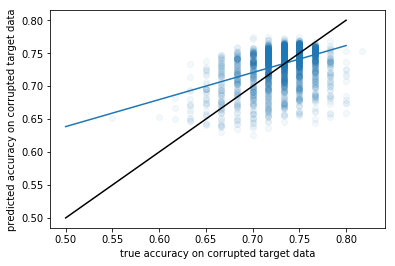

In [51]:
from scipy import stats

gradient, intercept, _, _, _ = stats.linregress(np.array(true_scores).flatten(), np.array(predicted_scores).flatten())

plt.scatter(true_scores, predicted_scores, alpha=0.05)

x1 = np.linspace(0.5, 0.8, 100)
plt.plot(x1, gradient * x1 + intercept, '-')

plt.xlabel("true accuracy on corrupted target data")
plt.ylabel("predicted accuracy on corrupted target data")
plt.plot([0.5, 0.8], [0.5, 0.8], color='black')
plt.show()